# Best Model: Gradient Boosting
- Link to competition [here](https://www.kaggle.com/c/titanic/overview)
- Streamlined notebook that tunes and improves upon gradient boosting, the best model from titanic.ipynb

## Contents<a class="anchor" id="contents"></a>
1. [Reading Data](#reading_data)
2. [Training Gradient Boosting](#training_models)
3. [Evaluation Statistics](#evaluation_statistics)
4. [Final Training and Submission](#final_training_and_submission)
5. [Results](#results)

# 1) Reading Data <a class="anchor" id="reading_data"></a>
[To contents](#contents)

In [107]:
# basic imports
import joblib
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# view parameters
from sklearn import set_config
set_config(print_changed_only=False)

# models
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

# model selection
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [108]:
# read in cleaned data from titanic.ipynb
train = pd.read_csv('data/train_cleaned.csv')
test = pd.read_csv('data/test_cleaned.csv')

X_train = pd.read_csv('data/split/train_features.csv')
X_val = pd.read_csv('data/split/val_features.csv')
X_test = pd.read_csv('data/split/test_features.csv')

y_train = pd.read_csv('data/split/train_labels.csv')
y_val = pd.read_csv('data/split/val_labels.csv')
y_test = pd.read_csv('data/split/test_labels.csv')

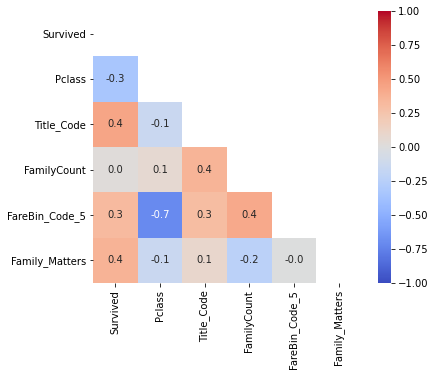

In [109]:
# generate correlation matrix heat map
plt.figure(figsize = (6,5))
matrix = np.triu(train.corr())
sns.heatmap(train.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix);

# 2) Training Gradient Boosting <a class="anchor" id="training_models"></a>
[To contents](#contents)
- Gradient boosting aggregates many weak models, learning from its own mistakes with each iteration to create one strong model
- Type of ensemble method, which combies multiple models to reduce bias and variance
- Takes sample from training data classifies examples, next model overweights misclassified examples from previous model
- Final selection based on weighted voting based on how well each model did in training
- When to use
    - Categorical or continuous target variable
    - Interested in significance of predictors
    - Prediction time is important
- When not to use
    - Transparency is important
    - Data is very noisy, boosting tends to overfit
    - Training time is important
- Key hyperparameters
    - `n_estimators` controls how many individual decision trees are built (should be more than random forest)
    - `max_depth` controls how deep each tree can go (should be shallower than random forest)
    - `learning_rate` facilitates how quickly and whether or not algorithm will find optimal solution, select a numerical value
        - Low learning rate is slow and may get stuck in local min
        - High learning rate jumps around and may never find optimal solution

- Use the training dataset using 5-Fold Cross-Validaiton to get a basic idea of the model's performance
- 5-Fold Cross-Validation shows the accuracy of the model when training on different subsets of the data

In [110]:
# prints results of GridSearchCV
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))
    
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        # prints mean and 2 standard deviations to each side
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [111]:
# view parameters
print(GradientBoostingClassifier())

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, random_state=None,
                           subsample=1.0, tol=0.0001, validation_fraction=0.1,
                           verbose=0, warm_start=False)


In [112]:
# fit model
gb = GradientBoostingClassifier()
parameters = {
    'n_estimators': [50, 250, 500],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.2, 0.5, 1]
}

cv = GridSearchCV(gb, parameters, cv=5)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 50}

0.854 (+/-0.064) for {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50}
0.854 (+/-0.064) for {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 250}
0.848 (+/-0.066) for {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500}
0.832 (+/-0.075) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.848 (+/-0.069) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
0.85 (+/-0.059) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
0.845 (+/-0.073) for {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50}
0.843 (+/-0.055) for {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 250}
0.845 (+/-0.049) for {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
0.854 (+/-0.064) for {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50}
0.848 (+/-0.049) for {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 250}
0.846 (+/-0.051) for {'learnin

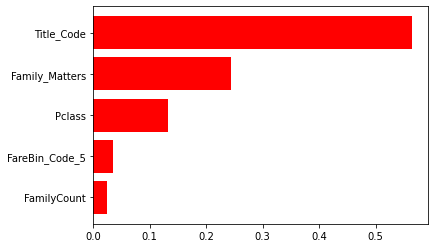

In [113]:
# generate feature importance plot
feat_imp = cv.best_estimator_.feature_importances_
indices = np.argsort(feat_imp)
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.barh(range(len(indices)), feat_imp[indices], color='r', align='center')
plt.show()

In [114]:
X_train.shape

(534, 5)

## 3) Evaluation Statistics<a class="anchor" id="evaluation_statistics"></a>
[To contents](#contents)
- Accuracy = # predicted correctly/total # examples
- Precision = # predicted to survive that actually survived / total # predicted to survive
- Recall = # predicted to survive that actually survived / total # that actually survived

In [115]:
# evaluates prediction time, accuracy, precision, recall
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                   accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   round((end - start)*1000, 1)))

In [116]:
# final evaluation of best model on test set
evaluate_model('gradient_boosting', cv.best_estimator_, X_test, y_test)

gradient_boosting -- Accuracy: 0.815 / Precision: 0.786 / Recall: 0.677 / Latency: 1.9ms


# 4) Final Training and Submission<a class="anchor" id="final_training_and_submission"></a>
[To contents](#contents)
- Train the model on the entire training set and create a submission

In [117]:
# import all cleaned data
features = train.drop(columns='Survived')
labels = train['Survived'].values.ravel()

In [118]:
# fit on complete training data
final_gb = GradientBoostingClassifier(learning_rate=0.05, max_depth=2, n_estimators=400)
final_gb.fit(features, labels)
joblib.dump(final_gb, 'models/best_model.pkl')

['models/best_model.pkl']

In [119]:
# write out submission
ids = pd.read_csv('data/test.csv')['PassengerId']
def submission(name, model):
    predictions = model.predict(test)
    predictions = predictions.astype(int)
    output = pd.DataFrame({'PassengerId' : ids, 'Survived': predictions})
    output.to_csv('submissions/{}_submission.csv'.format(name), index = False)

submission('best', joblib.load('models/best_model.pkl'))

# 5) Results<a class="anchor" id="results"></a>
[To contents](#contents)
- Gradient Boosting: 0.80861
- Rank: 362/13438 (top 2.69%)
- Rank (eliminate cheat submissions): 196/13272 (top 1.47%)